<a href="https://colab.research.google.com/github/drdarina/ds_workshop/blob/master/ow_classifier_ingame_notingame_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingame or not?

Train a tensorflow classifier to distinguish if we are ingame nor not.

We assume that the data is generated by the notebook 
https://github.com/DojoMadness/bayes-overwatch-classifier/blob/master/preprocessing/generate_ingame_notingame_images_from_hd.ipynb
and uploaded to google drive. You can also upload your own data by uncommented the relevant code part below.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from IPython import display
from keras.preprocessing.image import array_to_img, load_img, img_to_array
import gc
from random import sample

Using TensorFlow backend.


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Load data and preprocess

In [0]:
# clean up old results
for fn in list(os.walk('.'))[0][2]:
  if 'ingame_classifier' in fn:
    os.remove(fn)
!rm -rf 'test'
!rm -rf 'train'
!rm 'labels.p'

rm: cannot remove 'labels.p': No such file or directory


In [0]:
# load the zipped data from google drive
!pip install --quiet PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({'id': '1cN4XwLDjqqM4Ns9W-amLSuRwteTmjTr2'})
download.GetContentFile('overwatch_preprocessed_ingame_notingame.zip')

# uncomment to load the data from local
#from google.colab import files
#files.upload()


!unzip 'overwatch_preprocessed_ingame_notingame.zip'
!rm -rf 'overwatch_preprocessed_ingame_notingame.zip'

In [0]:
# load the label names and create a lookup dictionary that goes both ways

with open('labels.p', 'rb') as f:
  lbls = pickle.load(f)
print('There are {} labels: {}.'.format(len(lbls), ', '.join(lbls)))
label_lookup = {}
for idx, i in enumerate(lbls):
  label_lookup[idx] = i
  label_lookup[i] = idx
  
total_labels = len(lbls)

There are 2 labels: ingame, not_ingame.


In [0]:
# put all file paths in lists for easier access later
# files are organized train/test -> ingame/not_ingame
# resulting dictionary will have the keys train_ingame, test_ingame, 
# train_not_ingame, test_not_ingame and a list of all corresponding file paths as value

top_folder = '.'
path_dict = {}
for m in lbls:
  path_dict['train_'+m] = os.path.join(top_folder, 'train', m)
  path_dict['test_'+m] = os.path.join(top_folder, 'test', m)
  
file_lists = {}
for k, path in path_dict.items():
  file_lists[k] = [os.path.join(path, i) for i in os.listdir(path) if i.endswith('.png')]
  print('{}: {} images'.format(k, len(file_lists[k])))

train_ingame: 26843 images
test_ingame: 5240 images
train_not_ingame: 18343 images
test_not_ingame: 3270 images


In [0]:
# Balance the training data. We want the same amount of images per class, otherwise we'll just predict ingame for everything.
# We do this by randomly sampling from the larger array.

min_train = min([len(file_lists[i]) for i in file_lists.keys() if 'train' in i])

for m in lbls:
  file_lists['train_'+m] = sample(file_lists['train_'+m], min_train)

In [0]:
# Rewrite data to be in the format (file_name, label), to make keeping track of labels easier
# We take validation data from training data, using the same amount of ingame and not ingame images
# Number of validation data is hard coded to be 128
# If you are using a smaller batch size, you need to sample from the validation data during training

train = []
train_labels = []
test = []
test_labels = []
vali = []
vali_labels = []
for m in lbls:
  train += file_lists['train_'+m]
  train_labels += [label_lookup[m]] * len(file_lists['train_'+m])
  test += file_lists['test_'+m]
  test_labels += [label_lookup[m]] * len(file_lists['test_'+m])
  vali += sample(file_lists['test_'+m], 64)
  vali_labels += [label_lookup[m]] * 64
  
train = list(zip(train, train_labels))
test = list(zip(test, test_labels))
# remove validation data from test data, this isn't strictly necessary
test = [i for i in test if i[0] not in vali]
vali = list(zip(vali, vali_labels))

print('Found {} train and {} test images.'.format(len(train), len(test)))

# shuffle the training data
train = sample(train, len(train))
print('Training data example:')
train[:5]

Found 36686 train and 8382 test images.
Training data example:


[('./train/ingame/298376970-3956-OW.category.png', 0),
 ('./train/ingame/298778670-1911-OW.category.png', 0),
 ('./train/ingame/298734104-3711-OW.category.png', 0),
 ('./train/not_ingame/298401799-3114-OW.category.png', 1),
 ('./train/not_ingame/298734104-1611-OW.category.png', 1)]

In [0]:
# open sample and save image size
img_sample = img_to_array(load_img(train[0][0]))
img_size = img_sample.shape[:2]
img_size

(180, 720)

In [0]:
# preprocessing functions

def grayscale(img):
  # preprocessed images are already in grayscale, but as we are saving them as .jpeg,
  # they still have three channels when we load them
  img = img.mean(axis=-1)
  return np.expand_dims(img, -1)

def load_image(tup):
  # takes an image path and returns the grayscale image from the path in 4d
  img = load_img(tup[0])
  img = img_to_array(img)
  img = grayscale(img)
  return np.expand_dims(img, 0)

def onehot(labels):
  # takes an array of labels and returns their onehot encoding, who needs sklearn
  # will fail if labels is a list instead of a numpy array
  n_labels = len(labels)
  oh = np.zeros((n_labels, total_labels))
  for i in range(total_labels):
    oh[:, i] = np.where(labels==i, 1, 0)
  return oh

def load_files(file_list):
  # loads all the images in the file list and returns them in a numpy array with shape [len(file_list), *img_size, 1]
  # file list should contain tuples (path, label) that we generated above
  data = []
  labels = []
  for tup in file_list:
    labels.append(tup[1])
    data.append(load_image(tup))
  data = np.vstack(data)
  labels = np.array(labels)
  labels_encoded = onehot(labels)
  return data, labels, labels_encoded

In [0]:
# load validation data
vali_data, vali_labels, vali_onehot = load_files(vali)
print('Vali data has shape {}.'.format(vali_data.shape))

Vali data has shape (128, 180, 720, 1).


## Set up neural network

We are using a very simple network. The dropout (keep_prob) value is a paramter that needs to be set experimentally. A value between 0.6 and 0.9 seems to work best, but it's different depending on predictor.

Be careful that you set keep_prob = 1 for any inference you are doing after training.

In [0]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, *img_size, 1), name='input')
y =  tf.placeholder(tf.float32, shape=(None, total_labels), name='output')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [0]:
def conv_net(x, keep_prob):
  
    # define the filter sizes for all layers first
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 1, 16], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 16, 16], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 16, 32], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 32], mean=0, stddev=0.08))

    # 1 - convolution
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 2 - convolution
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 3 - convolution
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 4 - convolution
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 5 - flatten
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 6 - fully connected with dropout
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=256, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 7 - fully connected with dropout
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 8 - fully connected
    out = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=total_labels, activation_fn=None)
    return out

In [0]:
# these two variables are the hyperparameters
# to do: use variable learning rate
keep_probability = 0.8
learning_rate = 0.0001

# This line creates the neural network
# We can now use logits as if it was a value. That is, whenever we would use
# predict_proba in sklearn/keras, we will use logits instead. Then, when calling
# the respective function, we will pass it the x and keep_prob to be used as inputs
# to logits
logits = conv_net(x, keep_prob)

# Loss and Optimizer
# use sigmoid because we have birnary outputs
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
# cost will return the average cross entropy in the batch
cost = tf.reduce_mean(cross_entropy)
# classic
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
# You need to define what a correct prediction is. This function compares the index with the
# highest probability in the predictions to the index of the outcome.
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
# Since correct_pred will be either 0 or 1, just taking the mean works here
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Prediction
# The network returns unnormalized values. There are several ways to normalize them.
# We are using softmax here to get probabilities that sum up to 1
probability = tf.nn.softmax(logits, name='probability')
prediction = tf.argmax(logits, 1, name='prediction')

## Train the network

Instead of building complex functions, we are manually iterating through the training data using two index arrays. This avoids generating uncontrollable bugs by using some poorly understood data serving pipelines.

The images are too many to hold in memory. Hence we load them from disk for every batch.

Early stopping will happen if the accuracy and loss have not improved after a certain number of epochs. We only look at improvement in loss if the accuracy is no longer improving.

Every time we reach a possible early stopping step, we save the model in protobuf. There are other ways to do it (using checkpoints for example) but those are geared more towards restarting training at a later point. All we want is to grab the last model and pass to backend. This seems to be the simplest way to get there.

In [0]:
# set up batching
# we will just iterate through all of our files takig batch_size files per step
# there is no need to use any fancy generators in our use case
# as the image files are quite large, a batch size over 128 will fail
batch_size = 128
total_batches = int(len(train)/batch_size)
total_train = len(train)
# this line gives the indices of the first item in every batch
indices = [i*batch_size for i in range(total_batches)]
indices.append(total_train)

# parameters and placeholders

epochs = 100

# starting values, to be replaced while training
best_loss = 1
best_accuracy = 0

# minimal accuracy to start looking for early stopping
min_acc = 0.98
# number of steps before early stopping
stopping_steps = 50
# minimal number of steps before considering stopping
min_steps = 100
# counter for steps, for output purposes only
step = 0

# save loss and validation accuracy for plotting later
losses = []
val_acc = []

sess = tf.Session()
# Initializing the variables
init = tf.global_variables_initializer()
sess.run(init)

# set up saving the graph to protobuf
from tensorflow.python.framework import graph_util, ops
def save_graph_as_pb(filename):
  print('Saving {}'.format(filename))
  output_graph_def = graph_util.convert_variables_to_constants(sess, tf.get_default_graph().as_graph_def(), ['prediction', 'probability'])
  with tf.gfile.GFile(file_name, "wb") as f:
    f.write(output_graph_def.SerializeToString())


i = 0 # counter for batches, for output purposes only
# Training cycle
for epoch in range(epochs):
  print('Started epoch {}'.format(epoch + 1))
  for b1, b2 in zip(indices, indices[1:]):
    gc.collect()
    i += 1
    train_slice = train[b1:b2]
    feature_batch, _ , label_batch = load_files(train_slice)
    # actual training is done with this line
    sess.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})
    
    # calculate loss
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    losses.append(loss)
    
    # calculate accuracy. uncomment the line below if validation data is too 
    # large to fit in memory. validation data is too large to fit in memory
    # vali_data, _, vali_onehot = load_files(sample(vali, batch_size))
    acc = sess.run(accuracy, feed_dict={x: vali_data, y: vali_onehot, keep_prob: 1.})
    val_acc.append(acc)
   
    print('Epoch {:>1}, batch {:>2}:  '.format(epoch + 1, int(b2/batch_size)), end='')
    print('Loss: {:.4f}, Validation accuracy: {:.6f}, Step: {}'.format(loss, acc, step+1))
      
    # early stopping*
    # the criterion is two step: the accuracy should not improve and the loss
    # should not decrease for the current best accuracy for 50 steps
    # 50 steps are a lot but the network sometimes makes nice random jumps if 
    # you let it work for a while
    # we save model as protobuf every time we get a good value
    # so that we can use it after early stopping
    if i > min_steps:    
      if acc > min_acc:
        if acc > best_accuracy:
          best_accuracy = acc
          file_name = './ow_ingame_classifier_step{}.pb'.format(i)
          save_graph_as_pb(file_name)
          step = 0
        elif acc == best_accuracy:
          if loss < best_loss:
            best_loss = loss
            file_name = './ow_ingame_classifier_step{}.pb'.format(i)
            save_graph_as_pb(file_name)
            step = 0
          else:
            step += 1
        else:
          step += 1
      elif best_accuracy > min_acc: # we have already reached the min_acc threshold once, so this should count toward early stopping
        step += 1
      if step >= stopping_steps:
        print('Early stopping. Best accuracy was {}.'.format(best_accuracy))
        break
  if step >= stopping_steps:
    break

# save the model again if we somehow reached the end of training without early stopping
if i == epochs:
  print('Reached the end of training. Best accuracy was {}.'.format(best_accuracy))
  # if we have reached the number of epochs without early stopping, we still need to save model as protobuf
  file_name = './ow_ingame_classifier_step{}.pb'.format(i)
  save_graph_as_pb(file_name)

Started epoch 1
Epoch 1, batch  1:  Loss: 11.6760, Validation accuracy: 0.500000, Step: 1
Epoch 1, batch  2:  Loss: 0.7772, Validation accuracy: 0.851562, Step: 1
Epoch 1, batch  3:  Loss: 1.1811, Validation accuracy: 0.804688, Step: 1
Epoch 1, batch  4:  Loss: 0.8381, Validation accuracy: 0.945312, Step: 1
Epoch 1, batch  5:  Loss: 0.5508, Validation accuracy: 0.960938, Step: 1
Epoch 1, batch  6:  Loss: 0.6382, Validation accuracy: 0.945312, Step: 1
Epoch 1, batch  7:  Loss: 0.2590, Validation accuracy: 0.953125, Step: 1
Epoch 1, batch  8:  Loss: 0.1597, Validation accuracy: 0.976562, Step: 1
Epoch 1, batch  9:  Loss: 0.0689, Validation accuracy: 0.976562, Step: 1
Epoch 1, batch 10:  Loss: 0.0822, Validation accuracy: 0.976562, Step: 1
Epoch 1, batch 11:  Loss: 0.1143, Validation accuracy: 0.976562, Step: 1
Epoch 1, batch 12:  Loss: 0.1332, Validation accuracy: 0.976562, Step: 1
Epoch 1, batch 13:  Loss: 0.3485, Validation accuracy: 0.984375, Step: 1
Epoch 1, batch 14:  Loss: 0.0446, 

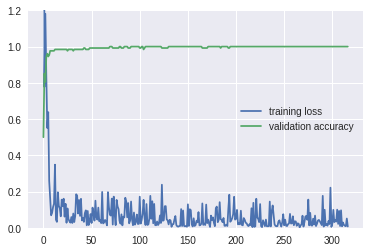

In [0]:
#plot loss and accuracy
plt.plot(range(len(losses)), losses, label='training loss')
plt.plot(range(len(val_acc)), val_acc, label='validation accuracy')
plt.ylim((0, 1.2))
_ = plt.legend()

## Evaluate the model with test data

In [0]:
# test data indexing
batch_size = 128
total_batches = int(len(test)/batch_size)
indices = [i*batch_size for i in range(total_batches)]
indices.append(len(test))

prob = np.zeros((len(test), total_labels))
y_test = np.zeros(len(test))

# generate test predictions
for b1, b2 in zip(indices, indices[1:]):
  test_slice = test[b1:b2]
  feature_batch, label_batch, _ = load_files(test_slice)
  prob[b1:b2, :]= probability.eval(feed_dict={x: feature_batch, keep_prob: 1.}, session=sess)
  y_test[b1:b2] = label_batch  

Predicted 8316 out of 8382 images correctly (99.21%).
              precision    recall  f1-score   support

      ingame       0.99      0.99      0.99      5176
  not_ingame       0.99      0.99      0.99      3206

   micro avg       0.99      0.99      0.99      8382
   macro avg       0.99      0.99      0.99      8382
weighted avg       0.99      0.99      0.99      8382



,labels,pred,proba,correct,wrong
count,8382.000000,8382.000000,8382.000000,8382.000000,8382.000000
mean,0.382486,0.381055,0.997529,0.992126,0.007874
std,0.486023,0.485675,0.024312,0.088391,0.088391
min,0.000000,0.000000,0.506481,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


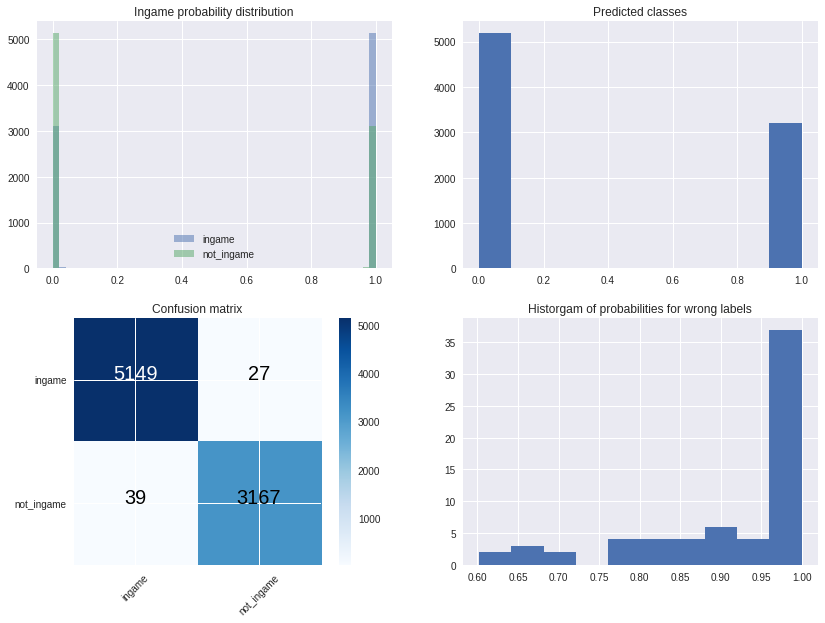

In [0]:
# plot probability distribution
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
for idx, m in enumerate(lbls):
  _ = plt.hist(prob[:,idx], bins=50, label=m, alpha=0.5)
plt.legend()
_ = plt.title('Ingame probability distribution')

# plot predicted classes distribution
plt.subplot(2,2,2)
pred = np.argmax(prob, 1)
_ = plt.hist(pred)
plt.title('Predicted classes')

total_test = len(test)
correct_pred = np.where(pred==np.array(y_test), 1, 0)
print('Predicted {} out of {} images correctly ({:.2f}%).'.format(sum(correct_pred), total_test, sum(correct_pred)*100 / total_test))

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, pred, target_names=lbls))

# plot confusion matrix
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, pred)
_ = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
_ = plt.colorbar()
tick_marks = np.arange(len(lbls))
plt.xticks(tick_marks, lbls, rotation=45)
_ = plt.yticks(tick_marks, lbls)
_ = plt.title('Confusion matrix')
from itertools import product as it_product
for i, j in it_product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > 2*cm.max()/3 else "black", size=20)
  
from pandas import DataFrame
results = DataFrame({'pred': pred, 'labels': y_test, 'proba': np.max(prob,1)})
results['correct'] = np.where(pred==y_test, 1, 0)
results['wrong'] = np.where(pred!=y_test, 1, 0)

# plot probabilities assigned to wrong results
plt.subplot(2,2,4)
results[results.wrong==1].proba.hist()
plt.title('Historgam of probabilities for wrong labels')
results.describe()

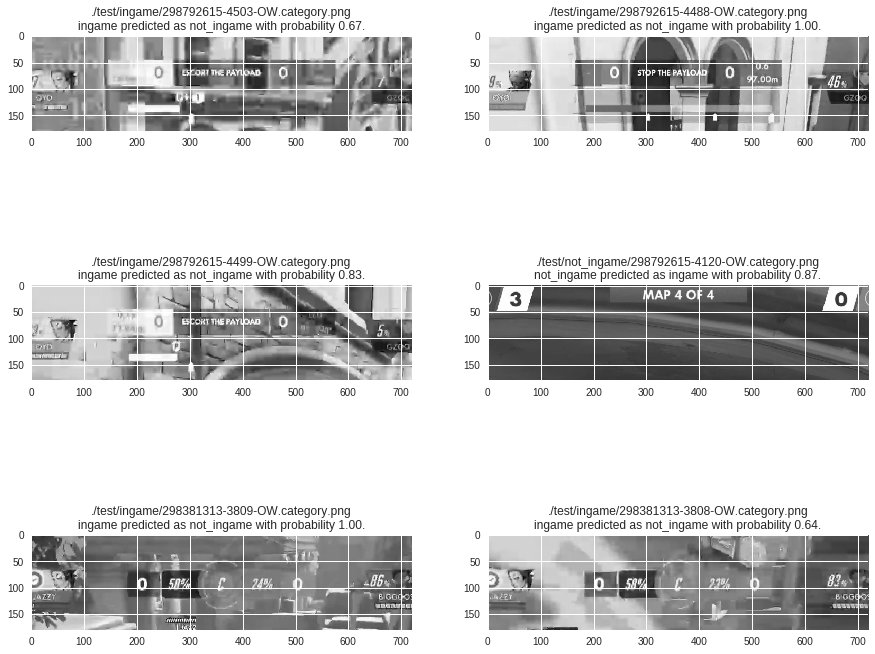

In [0]:
# take a look at the misclassified images
from pylab import imshow
results['filename'] = [i[0] for i in test]

wrong_results = results[results.wrong==1].sample(6).reset_index()
plt.figure(figsize=(15,13))
for i, wr in wrong_results.iterrows():
  plt.subplot(3,2, i+1)
  img = load_img(wr.filename)
  predicted_label = wr.pred
  real_label = wr['labels']
  proba = wr.proba
  imshow(img)
  plt.title('{}\n{} predicted as {} with probability {:.2f}.'.format(wr.filename, label_lookup[real_label], label_lookup[predicted_label], proba))

In [0]:
# close the session, so we can test the predictor loading
sess.close()

## Load the model

In [0]:
# helper function for loadig graph
def load_graph(file_name):
  with tf.gfile.GFile(file_name, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
  with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def)
  return graph

graph = load_graph(file_name)

In [0]:
# define all the tensors that are part of the graph. These may change, hence they were not saved with the graph from the start
x = graph.get_tensor_by_name('import/input:0')
keep_prob = graph.get_tensor_by_name('import/keep_prob:0')
out = graph.get_tensor_by_name('import/prediction:0')

with tf.Session(graph=graph) as sess:
  result = sess.run(out, feed_dict={x: vali_data[0:20], keep_prob: 1.0})
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
vali_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
# clean up after yourself

for fn in list(os.walk('.'))[0][2]:
  if 'ingame_classifier' in fn and fn != file_name.split('/')[1]:
    os.remove(fn)